# TensorFlow Assignment: Playing with GANs

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Khoi D. Vo </br>
Date: June 29, 2018

### Interpolating between images

As our “random noise” varies, so does the image our GAN generates. Perturbing the random input a little bit should perturb the image a little bit. This means that by taking small steps from one input to another, we can “animate” the transition from the image our GAN draws for the first to the one it draws for the second. Generate two random samples from a GAN, and interpolate between them (with, say, 100 steps).

In particular:
1. Train a GAN (using code from class).
2. Generate some noise `= np.random.uniform(-1, 1, [10, 32])` (for instance).
3. Get some fake images out using `sess.run(fake_X, {z: noise})`
4. Visualize them using `visualize_row()` and choose two images you like (say, image 1 and 3). Pull out `start` and `end` noise vectors (e.g., `start = noise[0]` and `end = noise[2]`).
5. Generate a list of ten vectors `steps = [..., ..., ...]`, where entry `i` is `i*10`% of the way from start to end.
6. `np.concatenate(steps)` (with appropriate axis) to get a new noise matrix. Run the GAN on that noise matrix, and visualize the 10 images you get as results.

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

/Users/KDV/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Helper Functions

In [3]:
def variables_from_scope(scope_name):
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

def visualize_row(images, img_width=28, cmap='gray'):
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.show()

### Hyperparameters

In [4]:
# Graph parameters
epsilon_dim = 42
hidden_dim = 256
image_size = 784

# Training parameters
batch_size = 50
iterations = 25000

### Generator

In [5]:
# Generator
def generator(epsilon):
    hidden_layer = tf.layers.dense(epsilon, hidden_dim, activation=tf.nn.relu)
    out_layer = tf.layers.dense(hidden_layer, image_size, activation=tf.sigmoid)
    return out_layer # fake image generated

### Discriminator

In [6]:
def discriminator(images):
    hidden_layer = tf.layers.dense(images, hidden_dim, name="D1", activation=tf.nn.relu)
    out_layer = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return out_layer

### Building the Graph

In [7]:
tf.reset_default_graph()

# Placeholders
inputs_g = tf.placeholder(tf.float32, [None, epsilon_dim])
inputs_d = tf.placeholder(tf.float32, [None, image_size])

# Generator
with tf.variable_scope("generator") as scope:
    gen_image = generator(inputs_g)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_fake = discriminator(gen_image)
    scope.reuse_variables()
    d_real = discriminator(inputs_d)

g_loss = -tf.reduce_mean(tf.log(d_fake))
d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))

optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))
optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))

initialize_all = tf.global_variables_initializer()

In [8]:
# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, epsilon_dim])

def next_feed_dict():
    return {inputs_d: mnist.train.next_batch(batch_size)[0],
            inputs_g: make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    _, _, loss, fake_data = sess.run([optimize_g, optimize_d, d_loss, gen_image], feed_dict=next_feed_dict())

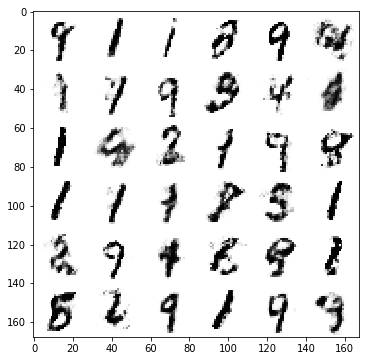

In [9]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, epsilon_dim])
    # Generate image from noise.
    g = sess.run(gen_image, feed_dict={inputs_g: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

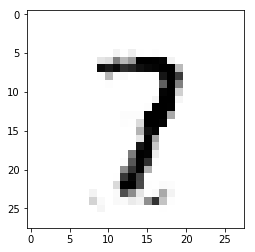

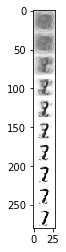

In [19]:
z = np.random.uniform(-1., 1., size=[10, epsilon_dim])
z_single = np.random.uniform(-1., 1., size=[1, epsilon_dim])
g = sess.run(gen_image, feed_dict={inputs_g: z})

start = z[0]
end = z[2]
z_range = end-start
z_single[0] = z_range

for i in range(10):
    z[i] = i*(.1*z_range)

g_1 = sess.run(gen_image, feed_dict={inputs_g: z_single})
g_2 = sess.run(gen_image, feed_dict={inputs_g: z})

g_1 = -1 * (g_1 - 1)
g_2 = -1 * (g_2 - 1)

visualize_row(g_1)
visualize_row(g_2[:10])